In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

gold_yellow = "#FFC000"

plt.style.use("dark_background")

In [2]:
df = gpd.read_file("../data/master.geojson")

In [3]:
df.head()

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,net_salary,population,distance_to_angers,distance_to_avignon,...,distance_to_rennes,distance_to_rouen,distance_to_saintbrieuc,distance_to_saintetienne,distance_to_strasbourg,distance_to_toulouse,distance_to_tours,dist_min,closest_metropolis,geometry
0,01004,01,84,882724.0,6542583.0,Ambérieu-en-Bugey,13.7,13460.0,481.386634,227.390682,...,585.373385,501.891964,676.571427,95.057840,342.181840,405.256373,390.767916,45.879279,Lyon,"POLYGON ((5.38637 45.93121, 5.38892 45.93320, ..."
1,01007,01,84,882682.0,6548067.0,Ambronay,13.5,2563.0,479.423210,232.793303,...,583.044624,497.657430,674.146914,98.542071,337.432535,408.804303,388.531487,48.741451,Lyon,"POLYGON ((5.40440 46.00778, 5.39779 46.01009, ..."
2,01014,01,84,906407.0,6580780.0,Arbent,13.5,3281.0,491.910607,269.530737,...,592.430505,489.484950,682.573590,138.224859,297.286527,448.270671,399.360905,87.894148,Lyon,"POLYGON ((5.71332 46.25667, 5.71983 46.25783, ..."
3,01024,01,84,866161.0,6578890.0,Attignat,12.9,3329.0,453.855171,261.397017,...,555.654896,463.493880,646.263640,111.697209,320.269383,417.976502,361.838430,63.123904,Lyon,"POLYGON ((5.16256 46.25622, 5.16464 46.25629, ..."
4,01025,01,84,849782.0,6581485.0,Bâgé-la-Ville,13.0,3142.0,437.452133,263.172045,...,539.526669,450.918833,630.241338,106.570254,327.904742,408.624114,345.563023,61.578670,Lyon,"POLYGON ((4.92091 46.30781, 4.92544 46.31070, ..."


In [4]:
def simulate_net_salary(
    xs,
    y0=12,
    base=12,
    alpha=0.07
):
    return (
        np.exp(- alpha * xs) * y0 + base
    )



In [5]:
from itertools import product

def grid_optimizer(alphas, y0s, bases, xs, ys, opt_function):
    
    best_score, best_params = 10, {}
    
    for alpha, y0, base in product(alphas, y0s, bases):
        predictions = simulate_net_salary(xs=xs, y0=y0, base=base, alpha=alpha)
        residuals = ys - predictions
        score = opt_function(residuals)
        if  score < best_score:
            best_params = {"alpha": alpha, "y0": y0, "base": base}
            best_score = score
    return best_score, best_params

def metric_function(residuals):
    return np.mean(np.abs(residuals))

In [6]:
scores = []

for city in tqdm(sorted(df["closest_metropolis"].unique())):
    df_temp = df[df["closest_metropolis"] == city]
    df_temp = df_temp[df_temp["libgeo"] != city]
    nb_cities = df_temp.shape[0]
    
    best_score, best_params = grid_optimizer(
        alphas=[0.01 * i for i in range(1, 21)],
        y0s=[12 + i for i in range(-8, 8)],
        bases=range(7, 13),
        opt_function=metric_function,
        xs=df_temp["dist_min"],
        ys=df_temp["net_salary"]
    )
    scores.append({"city": city, "score": best_score / df_temp["net_salary"].mean(), "nb_cities": nb_cities, **best_params})
    

100%|███████████████████████████████████████████| 34/34 [00:25<00:00,  1.32it/s]


In [7]:
scores = pd.DataFrame(scores)

In [8]:
scores.head()

,city,score,nb_cities,alpha,y0,base
0,Angers,0.045481,75,0.13,5,12
1,Avignon,0.070949,141,0.01,4,10
2,Besançon,0.068285,75,0.11,4,12
3,Bordeaux,0.066933,198,0.02,4,11
4,Brest,0.052730,87,0.11,4,12


In [15]:
import pyperclip

def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return "|" + df_formatted.to_csv(sep="|", index=False, ).replace("\n", "|\n|")[:-1]

pyperclip.copy(pandas_df_to_markdown_table(scores.round(2).sort_values("score")))

In [9]:
df.to_csv()

,city,score,nb_cities,alpha,y0,base
0,Angers,0.045481,75,0.13,5,12
27,Rennes,0.049178,143,0.09,6,12
11,Le Mans,0.049376,71,0.15,8,12
4,Brest,0.052730,87,0.11,4,12
17,Montpellier,0.054646,206,0.07,5,12
26,Reims,0.055399,109,0.06,4,12
31,Strasbourg,0.056059,105,0.01,6,9
20,Nantes,0.056359,245,0.06,4,12
13,Limoges,0.056411,96,0.14,4,12
7,Clermont-Ferrand,0.059518,104,0.09,6,12


In [10]:
np.sum(scores["score"] * scores["nb_cities"]) / scores["nb_cities"].sum()

0.08203151849644642

In [11]:
predictions = []

for _, (city, _, _, alpha, y0, base) in scores.iterrows():
    df_temp = df.copy()[df["closest_metropolis"] == city]
    df_temp = df_temp[df_temp["libgeo"] != city]
    
    df_temp["prediction"] = simulate_net_salary(df_temp["dist_min"], alpha=alpha, base=base, y0=y0)
    
    predictions.append(df_temp)
predictions = pd.concat(predictions)

In [12]:
predictions["residuals"] = predictions["net_salary"] - predictions["prediction"]

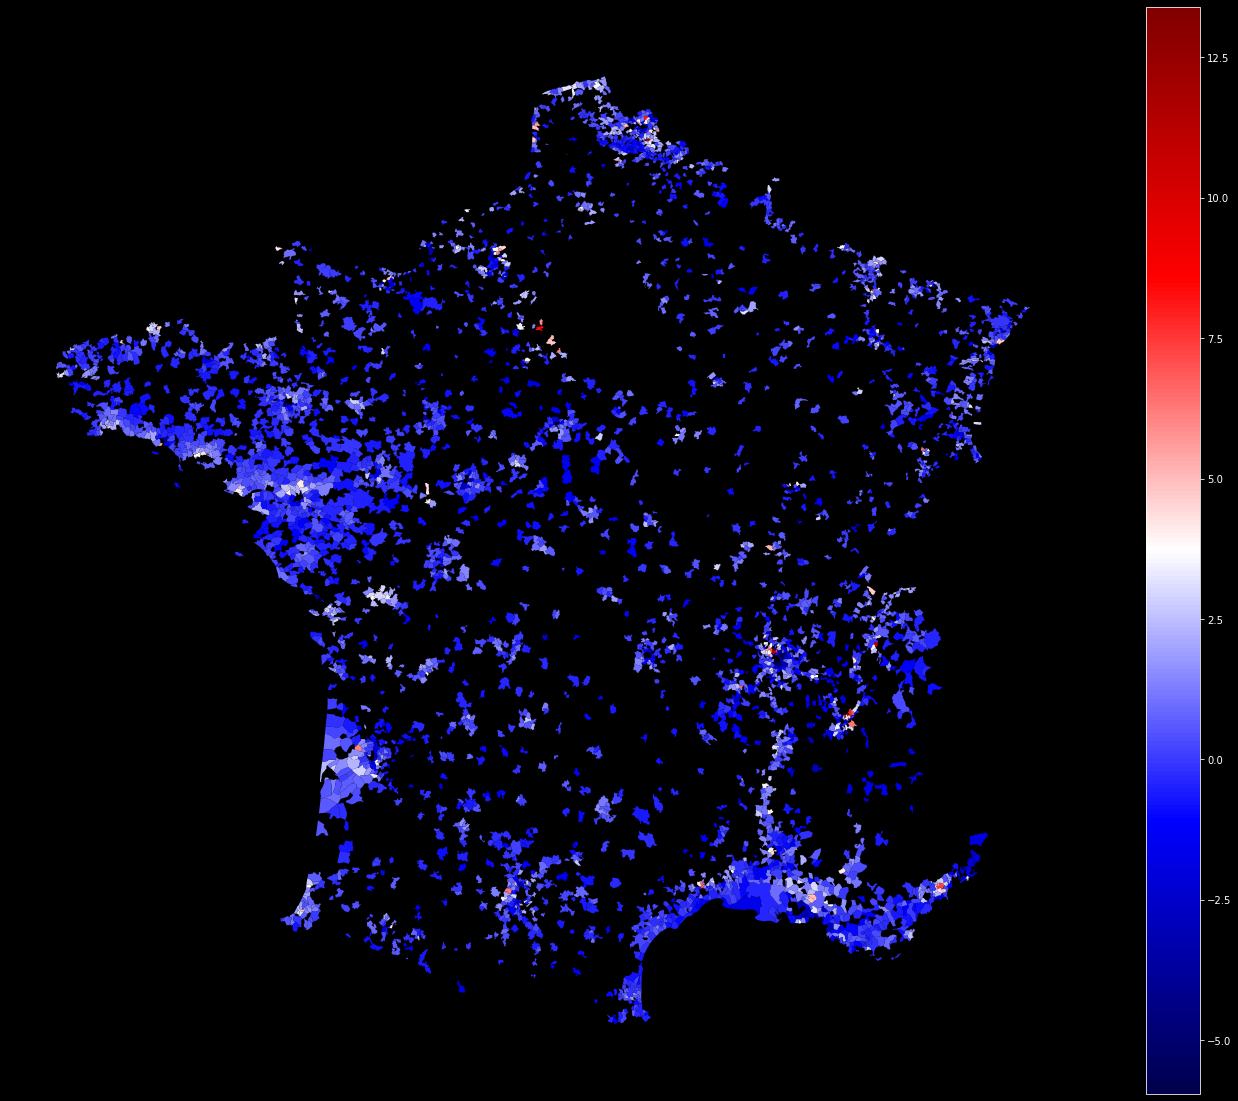

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(24, 20))
df_temp = predictions

df_temp = predictions[-predictions["closest_metropolis"].isin(["Paris - West", "Paris"])]

df_temp.plot(
    df_temp["residuals"],
    cmap="seismic",
    legend=True,
    ax=ax
)
ax.axis("off")
plt.show()

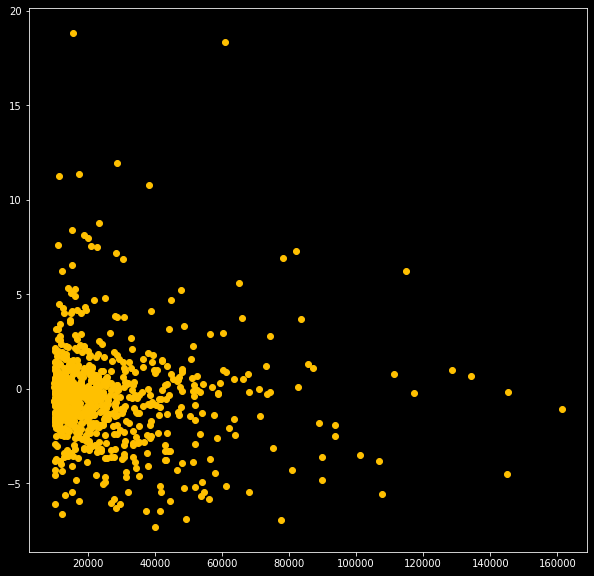

(834, 48)


In [20]:
df_temp = predictions[predictions["population"] > 10000]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(df_temp["population"], df_temp["residuals"], color=gold_yellow)

plt.show()

print(df_temp.shape)

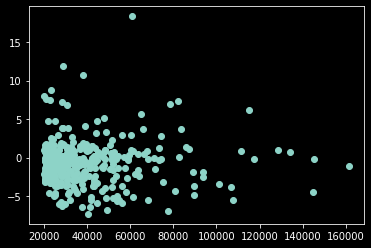